# Setup

In [ ]:
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
from geexhp import datavis as dvis
dvis.configure_matplotlib()

2025-03-07 22:38:32.868838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 22:38:32.869343: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 22:38:32.873195: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 22:38:32.882743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 22:38:32.900292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
tfrecord_file = "../data/train.tfrecord"

# Reading TFRecords

In [3]:
# Parsing function 
def parse_example(example_proto, feature_description):
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    dense_features = {
        key: tf.sparse.to_dense(value, default_value=0.0)
        if isinstance(value, tf.SparseTensor) else value
        for key, value in parsed_features.items()
    }
    return dense_features

In [4]:
# Only output variables
known_feature_description = {
    "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
    "OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
    "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
    "ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

    'C2H6': tf.io.FixedLenFeature([], tf.float32),
    'CH4': tf.io.FixedLenFeature([], tf.float32),
    'CO': tf.io.FixedLenFeature([], tf.float32),
    'CO2': tf.io.FixedLenFeature([], tf.float32),
    'H2O': tf.io.FixedLenFeature([], tf.float32),
    'N2': tf.io.FixedLenFeature([], tf.float32),
    'N2O': tf.io.FixedLenFeature([], tf.float32),
    'O2': tf.io.FixedLenFeature([], tf.float32),
    'O3': tf.io.FixedLenFeature([], tf.float32)
}

In [5]:
# Read TFRecord
dataset = tf.data.TFRecordDataset(tfrecord_file)
parsed_dataset = dataset.map(lambda x: parse_example(x, known_feature_description))

# Get best $n$ values

In [6]:
# Get samples from dataset
samples = []
for batch in parsed_dataset:
    samples.append(batch)

2025-03-07 22:40:45.246073: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Extracting values from samples into a dictionary
result = {key: [d[key] for d in samples] for key in samples[0]}

In [8]:
# Extracting values from the result dictionary into numpy arrays for each molecule
molecules = {
    # 'C2H6' : np.array([float(value.numpy()) for value in result['C2H6']]),
    'CH4' : np.array([float(value.numpy()) for value in result['CH4']]),
    'CO' : np.array([float(value.numpy()) for value in result['CO']]),
    'CO2' : np.array([float(value.numpy()) for value in result['CO2']]),
    'H2O' : np.array([float(value.numpy()) for value in result['H2O']]),
    'N2' : np.array([float(value.numpy()) for value in result['N2']]),
    'N2O' : np.array([float(value.numpy()) for value in result['N2O']]),
    'O2' : np.array([float(value.numpy()) for value in result['O2']]),
    'O3' : np.array([float(value.numpy()) for value in result['O3']])
}

In [ ]:
def analyse_histogram_interval_temperature(temperature, n_start=1, n_end=20, divs=1000, bins=200):
    # This function analyzes histogram intervals for temperature data.
    # It transforms the data using a power function (taking the 1/nth power) for a range of n values,
    # computes the histogram for each transformed dataset,
    # and calculates the "interval" as the sum of the widths of bins that contain nonzero counts.
    n_values = np.linspace(n_start, n_end, divs)

    area_array = []   
    intervals = []   

    for n_value in n_values:
        if n_value == 0.0:
            continue
        
        data = np.power(temperature, (1 / n_value))
        
        counts, bin_edges = np.histogram(data, bins=bins)

        valids = np.nonzero(counts)[0]
        interval = 0
        for i in valids:
            interval += bin_edges[i + 1] - bin_edges[i]
        intervals.append(interval)

        # Calculate the area under the histogram as the sum of (counts * bin width) for each bin.
        area = np.sum(counts * np.diff(bin_edges))
        area_array.append(area)

    max_index = np.argmax(intervals)

    plt.plot(n_values, intervals, color="tab:gray")
    plt.title(f'Histogram data interval with {bins} bins for temperature')

    plt.scatter(n_values[max_index], intervals[max_index], color='k',
                label=f'Maximum interval value \n n = {n_values[max_index]:.4f} \n interval = {intervals[max_index]:.4f} \n area = {area_array[max_index]:.4f}')
    plt.vlines(n_values[max_index], min(intervals), max(intervals), linestyles='dashed', color='tab:red')
    plt.hlines(max(intervals), min(n_values), n_values[max_index], linestyles='dashed', color='tab:red')

    plt.xlim((min(n_values), max(n_values)))
    plt.ylim((min(intervals), max(intervals) * 1.02))

    plt.xlabel(r'$n$ value')
    plt.ylabel(r'Data Interval')

    plt.legend(loc='lower right')
    plt.show()

    # Return the n value that produced the maximum interval.
    return n_values[max_index]


In [10]:
# Normalize the temperature data from the result dictionary
temperature = np.array([float(value.numpy()) for value in result['ATMOSPHERE-TEMPERATURE']])
temperature = (temperature - min(temperature)) / (max(temperature) - min(temperature))

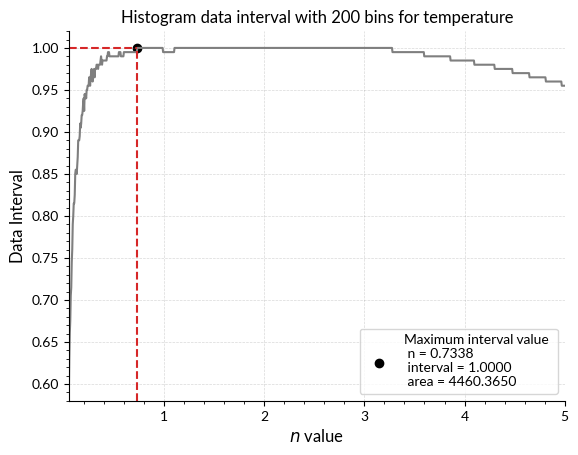

In [11]:
best_n_temp = analyse_histogram_interval_temperature(temperature, n_start=0.05, n_end=5)

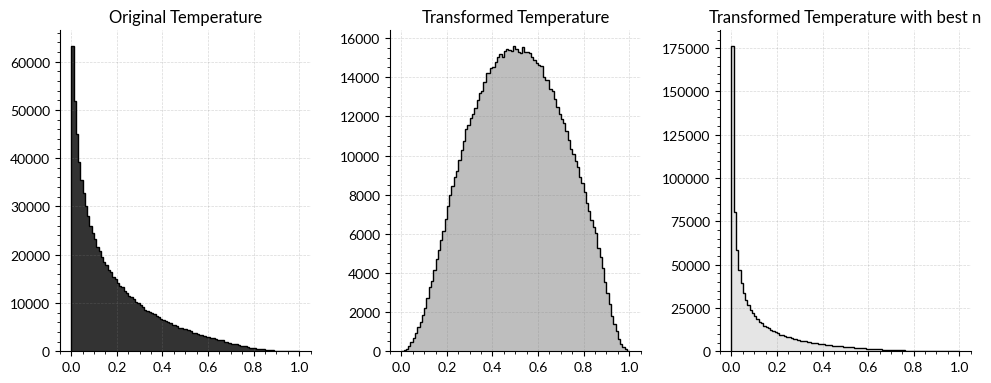

In [39]:
bins = 100

fig, axs = plt.subplots(1, 3, figsize = (10,4))

# Plot original temperature data
axs[0].hist(temperature, bins=bins, color="k", histtype="step")
axs[0].hist(temperature, bins=bins, color="k", alpha=0.8)
axs[0].set_title('Original Temperature')

# Transform temperature data and plot with 3
temp_tranformed = np.power(temperature, (1/3))
axs[1].hist(temp_tranformed, bins=bins, color="k", histtype="step")
axs[1].hist(temp_tranformed, bins=bins, color="tab:gray", alpha=0.5)
axs[1].set_title('Transformed Temperature')

# Transform temperature data and plot with best_n_temp
# Wrost case 
temp_tranformed = np.power(temperature, (1/ best_n_temp))
axs[2].hist(temp_tranformed, bins=bins, color="k", histtype="step")
axs[2].hist(temp_tranformed, bins=bins, color="tab:gray", alpha=0.2)
axs[2].set_title('Transformed Temperature with best n')

plt.tight_layout();

In [19]:
def analyse_histogram_area(molecule, n_start = 1, n_end = 20, divs = 1000, bins = 200):
    # Do the same analysis than before but for a specific molecule
    n_values = np.linspace(n_start, n_end, divs)

    area_array = []
    intervals = []

    for n_value in n_values:
        if n_value == 0.0:
            continue
        
        data = np.power(molecules[molecule], (1/n_value))
        
        counts, bin_edges = np.histogram(data, bins=bins)

        valids = np.nonzero(counts)[0]
        interval = 0
        for i in valids:
            interval += bin_edges[i+1] - bin_edges[i]
        intervals.append(interval)

        area = np.sum(counts * np.diff(bin_edges))
        area_array.append(area)

    max_index = np.argmax(intervals)

    plt.plot(n_values, intervals, color="tab:gray")
    plt.title(f'Histogram data interval with {bins} bins for {molecule}')

    plt.scatter(n_values[max_index], intervals[max_index], color = 'k',
                label = f'Maximum interval value \n n = {n_values[max_index]:.4f} \n interval = {intervals[max_index]:.4f} \n area = {area_array[max_index]:.4f}')
    plt.vlines(n_values[max_index], min(intervals), max(intervals), linestyles='dashed', color = 'tab:red')
    plt.hlines(max(intervals), min(n_values), n_values[max_index], linestyles='dashed', color = 'tab:red')

    plt.xlim((min(n_values), max(n_values)))
    plt.ylim((min(intervals), max(intervals)*1.02))

    plt.xlabel(r'$n$ value')
    plt.ylabel(r'Data Interval')

    plt.legend(loc = 'lower right')
    plt.show()


    return n_values[max_index]

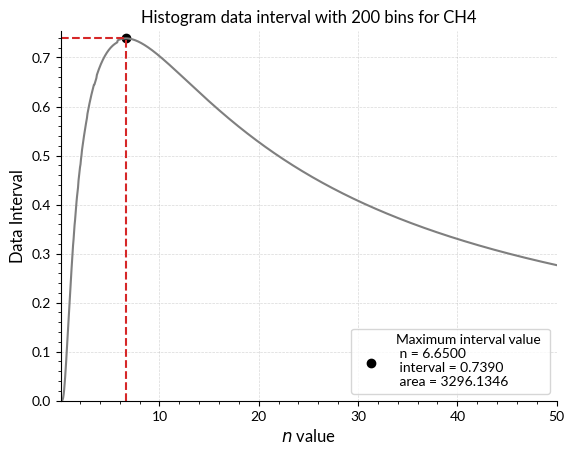

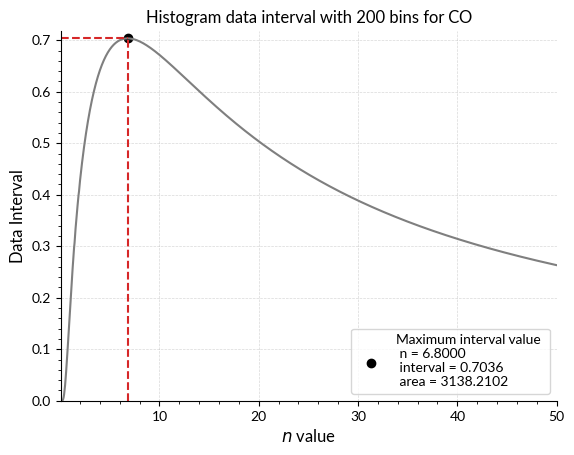

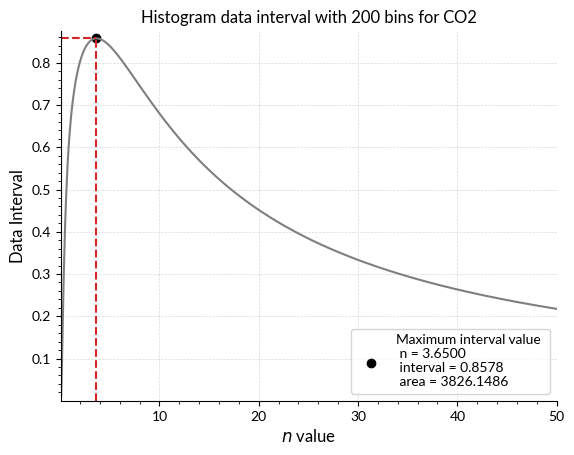

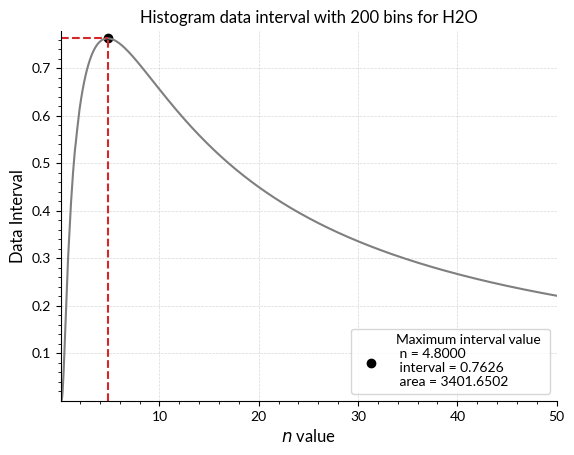

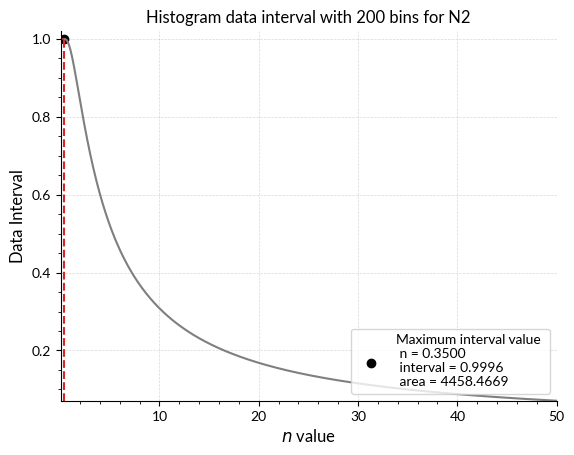

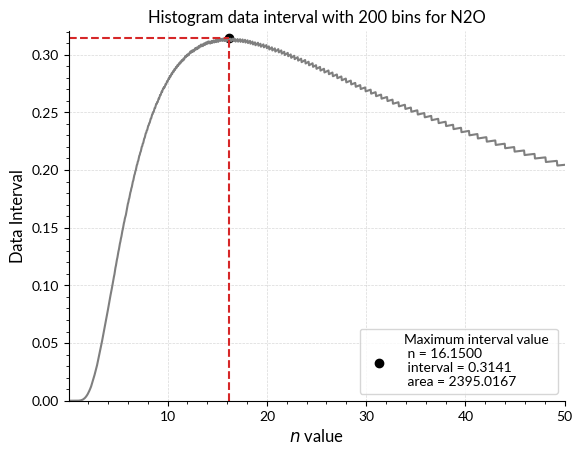

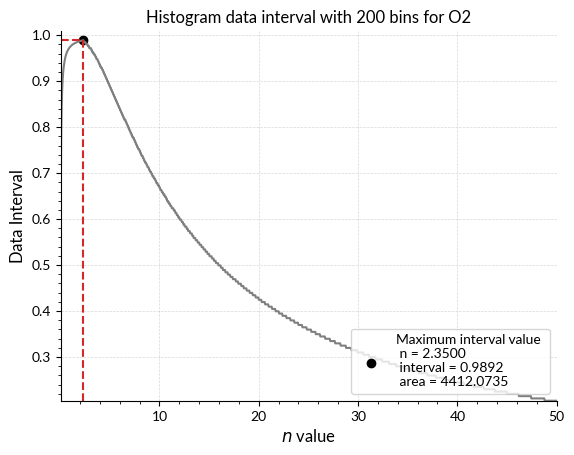

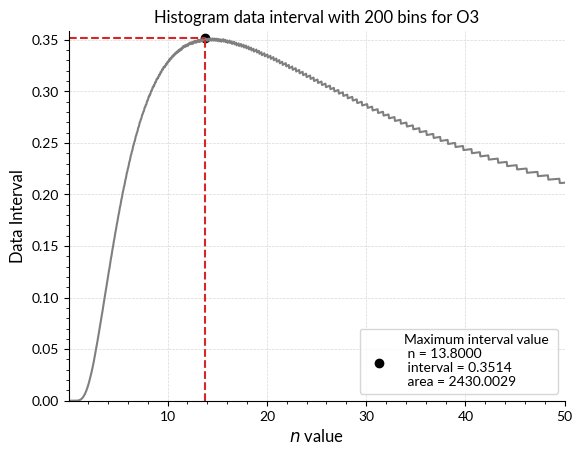

In [20]:
best_n_values = {}

for mol_key in list(molecules.keys()):
    best_n_values[mol_key] = float(analyse_histogram_area(mol_key, n_start=0.05, n_end=50))

In [21]:
# Add the best n value for temperature to the dictionary
best_n_values['ATMOSPHERE-TEMPERATURE'] = float(3)

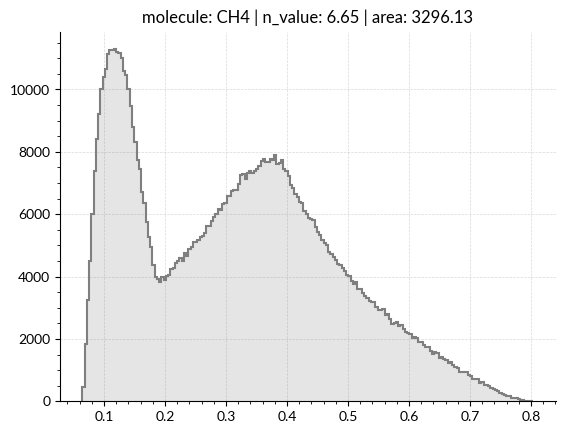

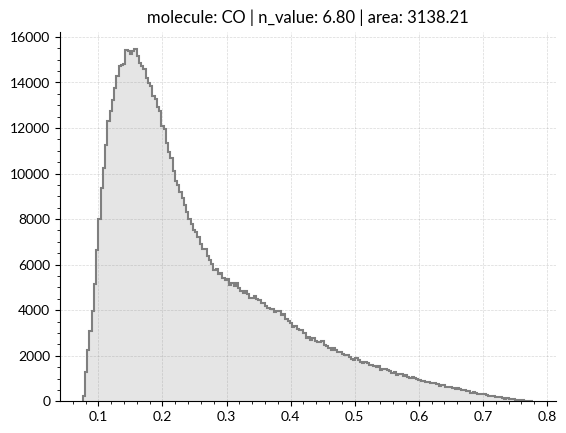

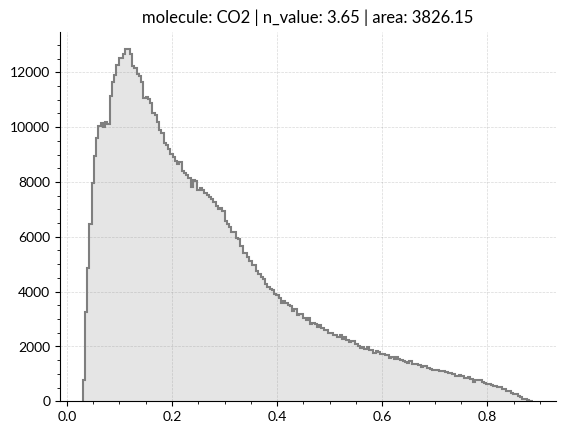

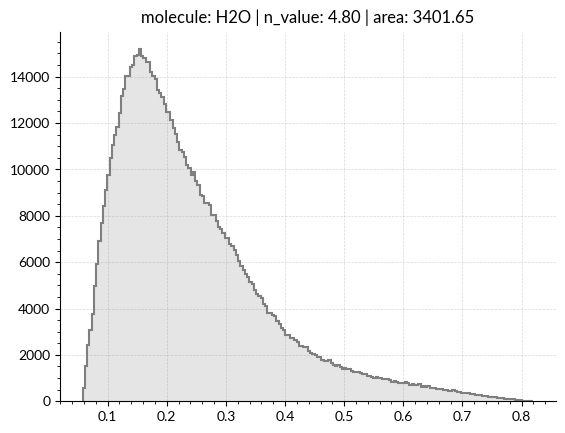

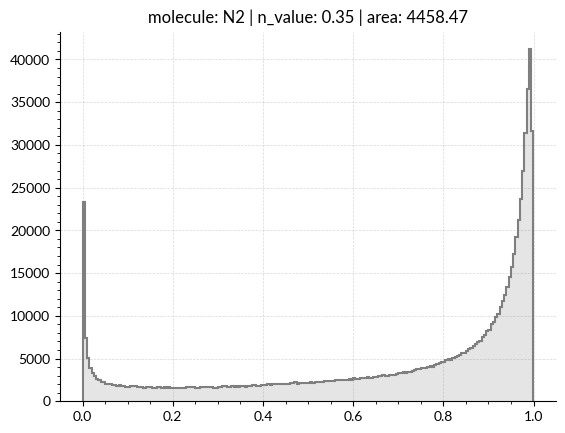

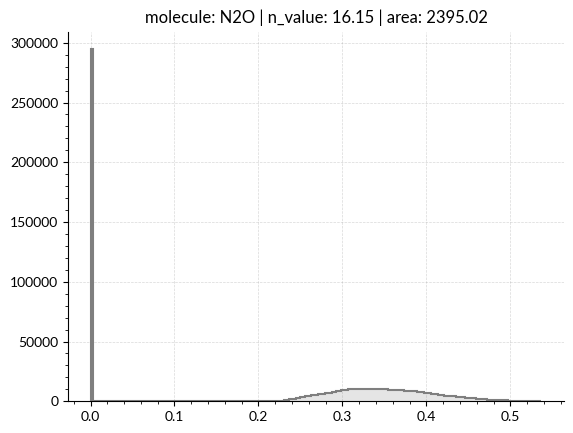

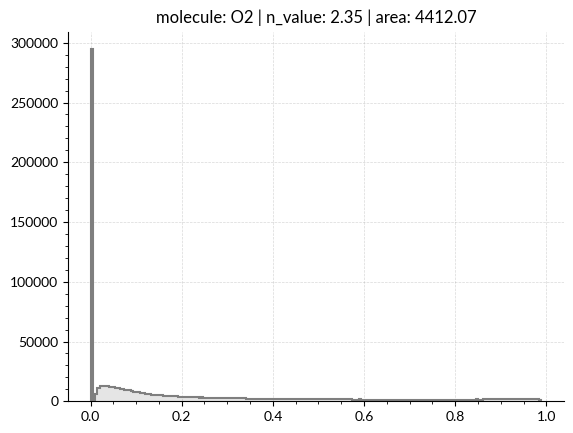

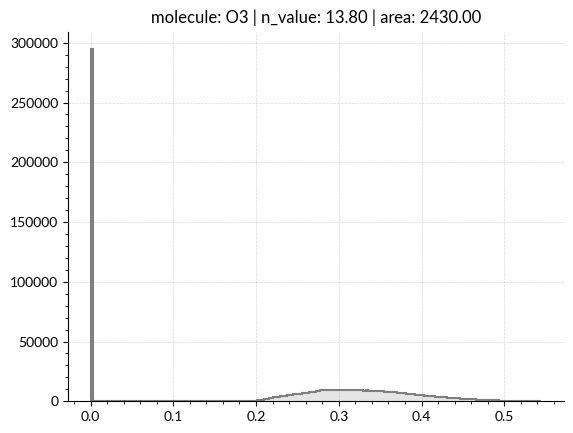

In [23]:
# Let's plot the histograms for each molecule using the best n value
bins = 200

for i, molecule in enumerate(list(molecules.keys())):
    data = np.power(molecules[molecule], (1/best_n_values[molecule]))
    counts, bin_edges = np.histogram(data, bins=bins)
    area = np.sum(counts * np.diff(bin_edges))
    
    plt.hist(data, bins=bins, histtype="step", color="tab:gray", lw=1.5)
    plt.hist(data, bins=bins, color="tab:gray", alpha=0.2)
    plt.title(f'molecule: {molecule} | n_value: {best_n_values[molecule]:.2f} | area: {area:.2f}')
    # plt.ylim((0, 2000))
    plt.show()

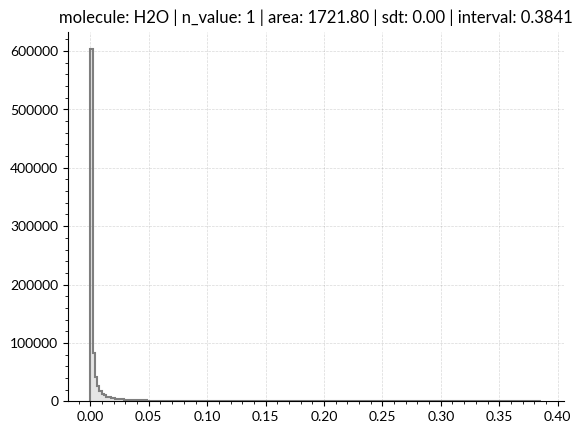

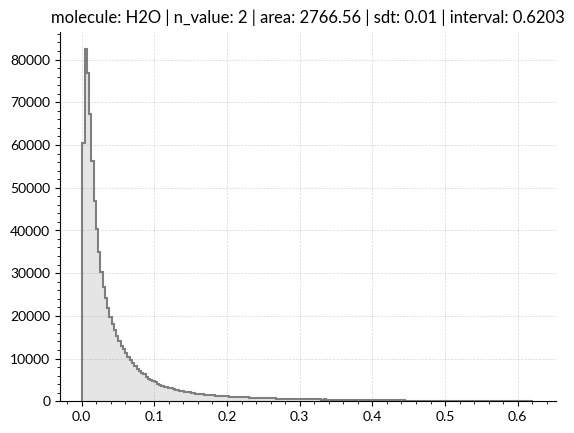

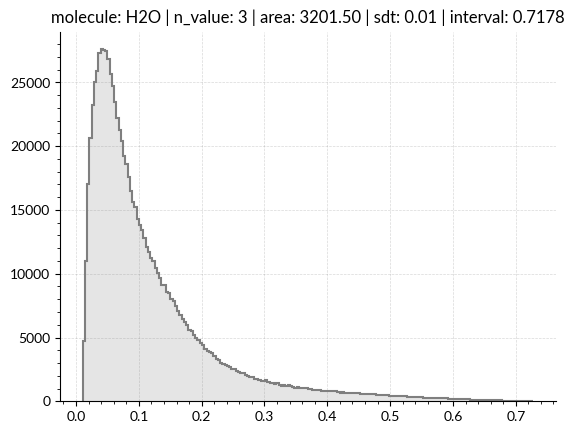

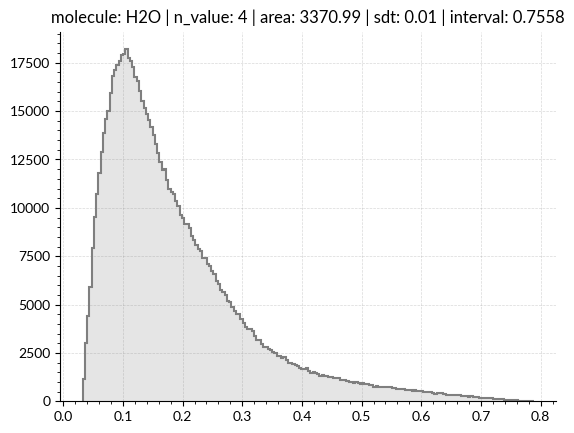

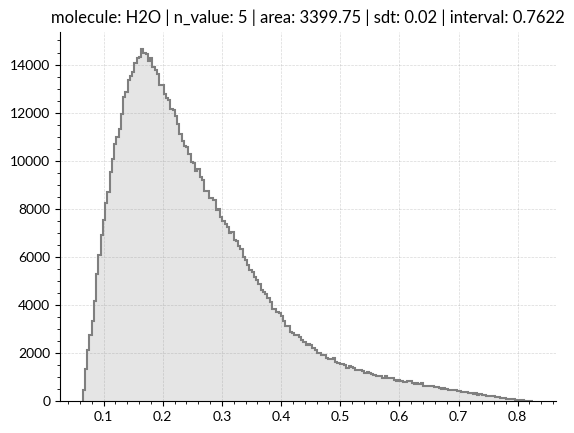

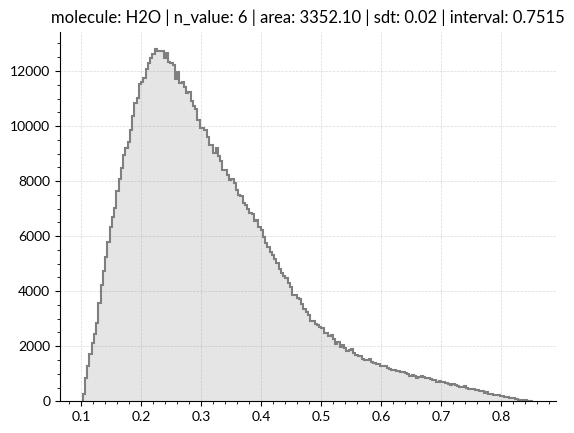

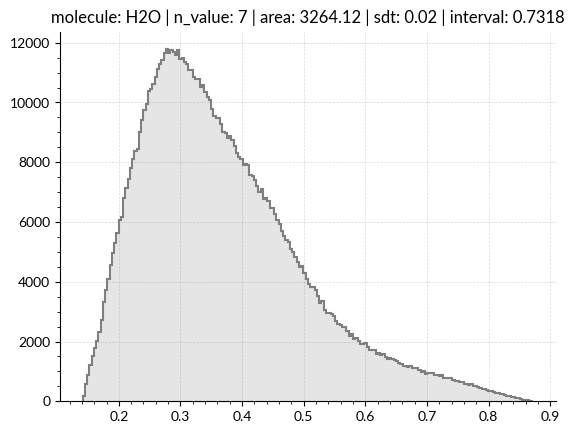

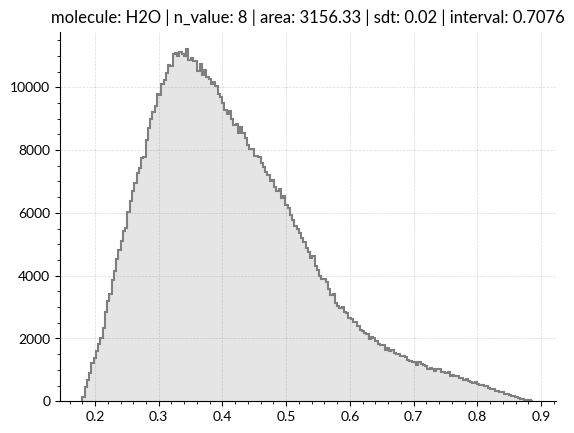

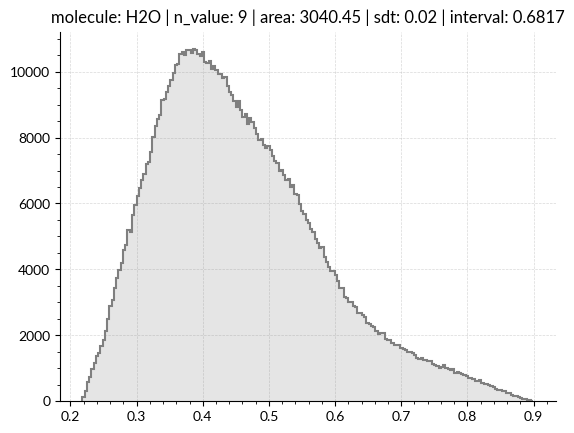

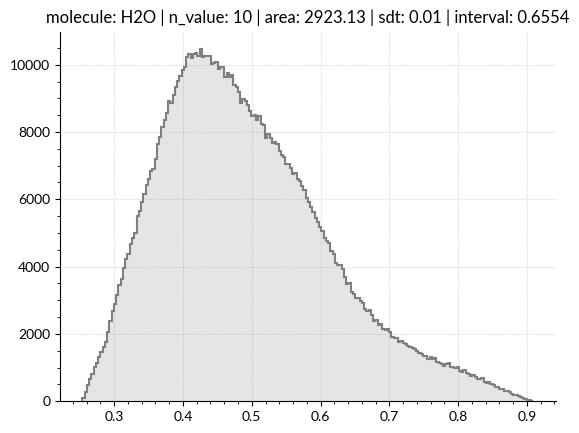

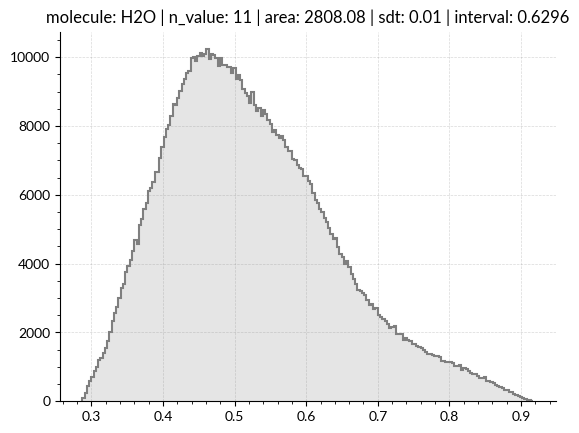

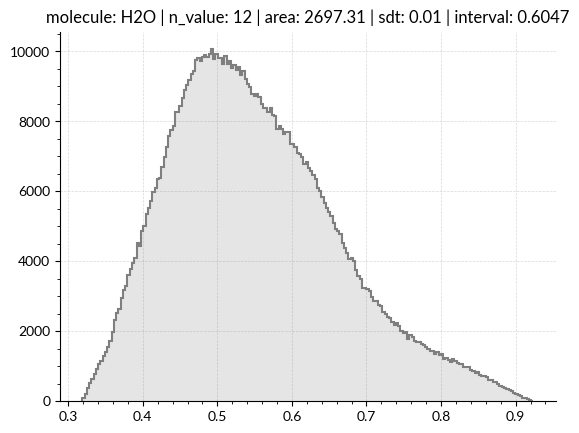

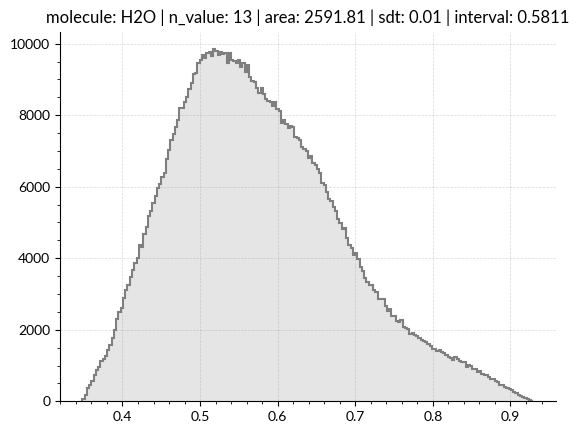

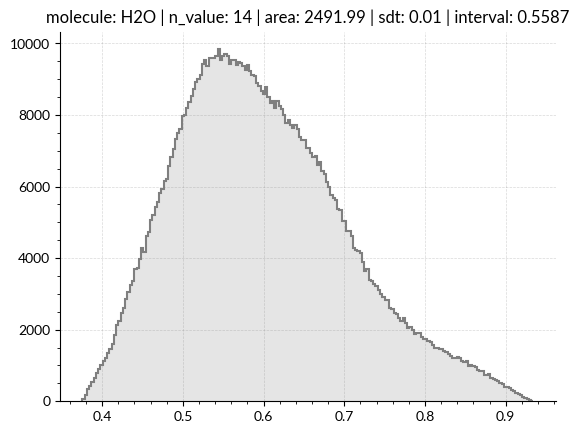

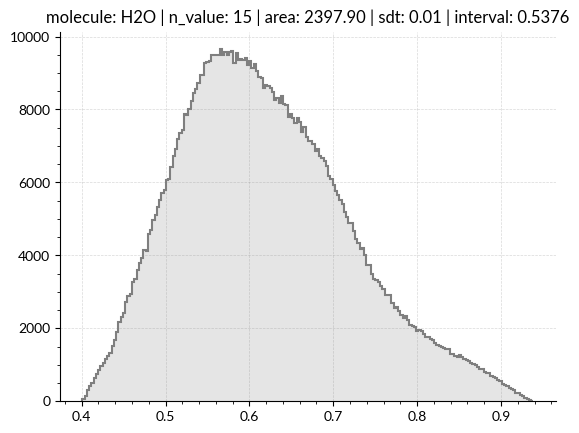

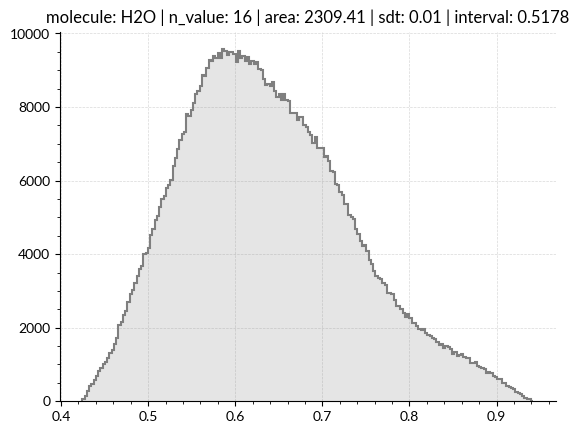

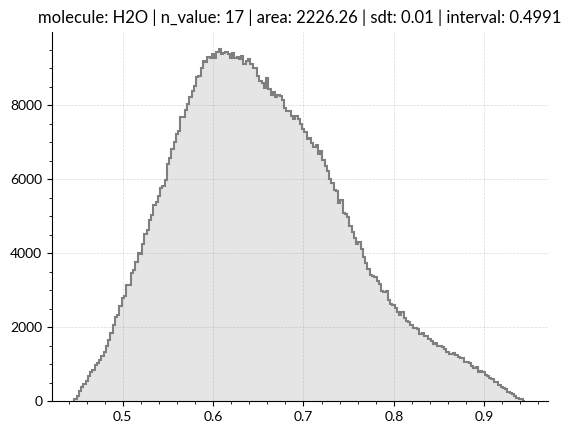

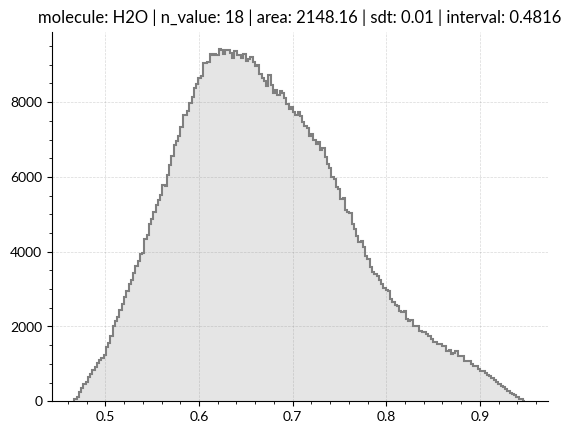

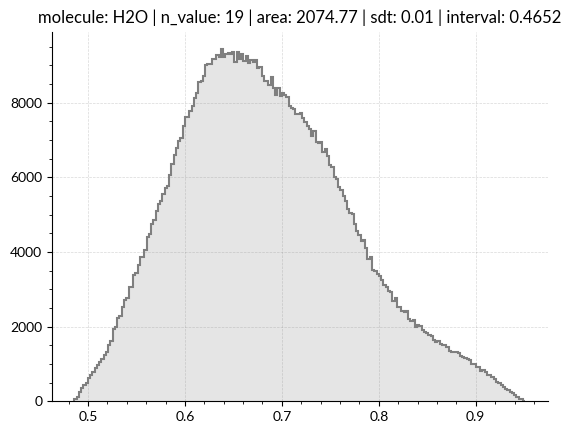

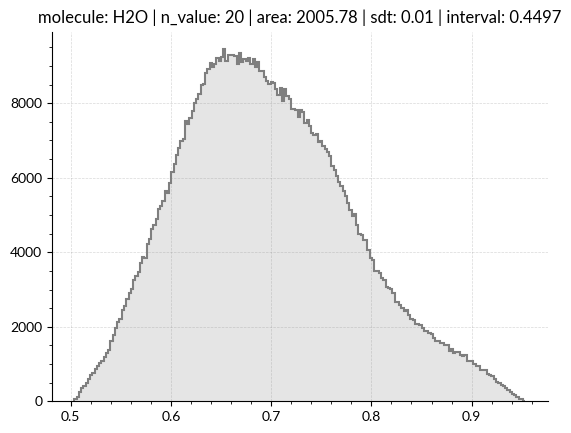

In [24]:
# Let's see how a power transformation with different n values affects 
# the histogram of the H2O molecule
n_values = np.arange(20)+1
molecule = 'H2O'
bins = 200

for n_value in n_values:
    data = np.power(molecules[molecule], (1/n_value))
    counts, bin_edges = np.histogram(data, bins=bins)

    valids = np.nonzero(counts)[0]
    interval = 0
    for i in valids:
        interval += bin_edges[i+1] - bin_edges[i]

    area = np.sum(counts * np.diff(bin_edges))

    spread_std = np.std(data)**2
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    plt.hist(data, bins=bins, histtype="step", color="tab:gray", lw=1.5)
    plt.hist(data, bins=bins, color="tab:gray", alpha=0.2)
    plt.title(f'molecule: {molecule} | n_value: {n_value} | area: {area:.2f} | sdt: {spread_std:.2f} | interval: {interval:.4f}')
    # plt.ylim((0, 2000))
    plt.show()

In [25]:
best_n_values

{'CH4': 6.65,
 'CO': 6.8,
 'CO2': 3.65,
 'H2O': 4.8,
 'N2': 0.35000000000000003,
 'N2O': 16.150000000000002,
 'O2': 2.35,
 'O3': 13.8,
 'ATMOSPHERE-TEMPERATURE': 3.0}

Best $n$ values from the training set.

```python
{'C2H6': 13.650000000000002,
'CH4': 6.65,
'CO': 6.8,
'CO2': 3.65,
'H2O': 4.8,
'N2': 0.35000000000000003,
'N2O': 16.150000000000002,
'O2': 2.35,
'O3': 13.8,
'ATMOSPHERE-TEMPERATURE': 3.0}
```

The function examines how a power transformation affects the data's distribution. For each $ n $ in a specified range, it transforms the original data $ x $ using the relation $ y = x^{\frac{1}{n}} $, thereby altering its distribution. It then computes a histogram of the transformed data by dividing it into a fixed number of bins. From the histogram, two key quantities are calculated: an "interval" and an "area." The interval is defined as the sum of the widths of all bins that contain at least one data point, which can be mathematically expressed as

$
\text{Interval}(n) = \sum_{i: \text{count}_i > 0} (b_{i+1} - b_i),
$

where $ b_i $ are the bin edges and $\text{count}_i$ are the counts in each bin. In parallel, the area under the histogram is computed as

$
\text{Area}(n) = \sum_{i} \text{count}_i \cdot (b_{i+1} - b_i),
$

which represents a Riemann sum approximation of the integral of the histogram. This area essentially approximates the total "weight" or cumulative frequency of the data across its range. The function then identifies the value of $ n $ that maximizes the interval, meaning that the transformed data achieves the widest spread or support. This optimal $ n $ is both highlighted in the plot and returned, providing a parameter choice that best reveals the underlying structure of the data.